In [1]:

import strax
import straxen
# import cutax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import datetime

from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
from scipy.optimize import curve_fit
import scipy.stats as stats

from immutabledict import immutabledict
from itertools import chain


In [2]:

st = straxen.contexts.xenonnt_online()


In [3]:

# function that takes a run, cut the events and the hitlets (in n_pmt
# and area rispectively) and find all the hitlets inside some event. Then
# compute the timings of each hitlet inside the events and return them

def create_timings(run_id,seconds_range=(0,15000),events_pmt_cut=10,hitlets_area_cut=0,n_events=1000):
    
    # load events and hitlets
    events = st.get_array(run_id,'events_nv',seconds_range=seconds_range,keep_columns=('n_contributing_pmt','time','endtime'),progress_bar=False)
    hitlets = st.get_array(run_id,'hitlets_nv',seconds_range=seconds_range,keep_columns=('time','area'),progress_bar=False)
    
    # cut events and hitlets
    events = events[events['n_contributing_pmt']>=events_pmt_cut]
    hitlets = hitlets[hitlets['area']>=hitlets_area_cut]
    
    # rescale the number of events in case and print a warning message
    if len(events) < n_events:
        print('Warning: the number of events for run '+str(run_id)+' after the cut is less than '+str(n_events))
        n_events = len(events)
        

    # create the mask to find the hitlets inside the events
    hitlets = hitlets[hitlets['time']<=events[n_events-1]['endtime']]
    global_mask = False
    hits_per_event = []
    i = 0
        
    for event in events[:n_events]:

        i += 1
        print('Adding mask for event '+str(i)+' out of '+str(n_events),end='\r')
        
        mask1 = hitlets['time'] >= event['time']
        mask2 = hitlets['time'] <= event['endtime']
        mask = np.array(mask1 & mask2)
        n_of_hits = len(mask[mask==True])
        if n_of_hits == 0:
            print('\n',event['endtime']-event['time'])
            print(event['n_contributing_pmt'])

        global_mask |= mask
        hits_per_event += [n_of_hits]
        
    print('\nAll masks added.')
    
        
    # mask the hitlets that are not inside the events
    hitlets_in_events = hitlets[global_mask]
    print('Number of hitlets in events found:',len(hitlets_in_events))
    
    # split the hitlets and compute the time differences
    hitlets_split = np.split(hitlets_in_events,np.cumsum(hits_per_event))[:-1]    
    times = np.array([ hitlets_split[i]['time'] - hitlets_split[i][0]['time'] for i in range(len(hitlets_split)) ],dtype=object)
    timings = list(chain.from_iterable(times))
    
    # release memory
    events = 0
    hitlets = 0
    
    return timings


In [4]:

# define the runs on which apply the algorithm to find the
# hitlet timings

starting_date = datetime.date(2022,4,8)
ending_date = datetime.date(2022,9,15)
day_step = 7

dates_of_the_runs = [starting_date]
today = starting_date
while today < ending_date:
    today += datetime.timedelta(days=7)
    dates_of_the_runs.append(today)

dates_of_the_runs = np.array(dates_of_the_runs[:-1])


In [22]:

# define the runs on which apply the algorithm to find the
# hitlet timings

starting_date = datetime.date(2022,3,1)
ending_date = datetime.date(2022,7,1)
day_step = 10

dates_of_the_runs = [starting_date]
today = starting_date
while today < ending_date:
    today += datetime.timedelta(days=day_step)
    dates_of_the_runs.append(today)

dates_of_the_runs = np.array(dates_of_the_runs[:-1])


In [5]:
dates_of_the_runs

array([datetime.date(2022, 4, 8), datetime.date(2022, 4, 15),
       datetime.date(2022, 4, 22), datetime.date(2022, 4, 29),
       datetime.date(2022, 5, 6), datetime.date(2022, 5, 13),
       datetime.date(2022, 5, 20), datetime.date(2022, 5, 27),
       datetime.date(2022, 6, 3), datetime.date(2022, 6, 10),
       datetime.date(2022, 6, 17), datetime.date(2022, 6, 24),
       datetime.date(2022, 7, 1), datetime.date(2022, 7, 8),
       datetime.date(2022, 7, 15), datetime.date(2022, 7, 22),
       datetime.date(2022, 7, 29), datetime.date(2022, 8, 5),
       datetime.date(2022, 8, 12), datetime.date(2022, 8, 19),
       datetime.date(2022, 8, 26), datetime.date(2022, 9, 2),
       datetime.date(2022, 9, 9)], dtype=object)

In [6]:

# get all the runs available
df = st.select_runs(run_mode=('background_linked','nVeto_self_trigger'),available='events_nv',exclude_tags=('abandon','messy'))


Checking data availability:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
df

,name,number,mode,end,source,start,tags,livetime,peak_basics_available,events_nv_available,raw_records_available
2358,048215,48215,background_linked,2022-10-18 06:05:19.525,none,2022-10-18 04:48:36.058,"_sr1_preliminary,phase1",0 days 01:16:43.467000,True,True,False
2359,048214,48214,background_linked,2022-10-18 04:47:41.587,none,2022-10-17 22:47:37.674,"warm_spot,_sr1_preliminary,phase1",0 days 06:00:03.913000,True,True,False
2360,048213,48213,background_linked,2022-10-17 22:45:04.528,none,2022-10-17 16:45:00.782,"warm_spot,_sr1_preliminary,phase1",0 days 06:00:03.746000,True,True,False
2361,048212,48212,background_linked,2022-10-17 16:44:08.926,none,2022-10-17 12:44:05.856,"warm_spot,_sr1_preliminary,phase1",0 days 04:00:03.070000,True,True,False
2362,048211,48211,background_linked,2022-10-17 12:43:12.604,none,2022-10-17 11:10:09.108,"_sr1_preliminary,phase1",0 days 01:33:03.496000,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
10819,039754,39754,nVeto_self_trigger,2022-02-27 18:03:01.038,,2022-02-27 17:02:56.034,,0 days 01:00:05.004000,False,True,False
10821,039752,39752,nVeto_self_trigger,2022-02-27 17:02:33.080,,2022-02-27 16:02:30.267,,0 days 01:00:02.813000,False,True,False
10824,039749,39749,nVeto_self_trigger,2022-02-27 16:02:07.062,,2022-02-27 15:02:05.136,,0 days 01:00:01.926000,False,True,False
10827,039746,39746,nVeto_self_trigger,2022-02-27 15:01:42.321,,2022-02-27 14:01:41.216,,0 days 01:00:01.105000,False,True,False


In [12]:
df.loc[df['start']==dates_of_the_runs[0]]

,name,number,mode,end,source,start,tags,livetime,peak_basics_available,events_nv_available,raw_records_available


In [11]:
df.loc[df['start']==dates_of_the_runs[0]].iloc[0]['name']

IndexError: single positional indexer is out-of-bounds

In [8]:

# get the runs
runs = []
for date in dates_of_the_runs:
    run_id = df.loc[df['start']==date].iloc[0]['name']
    runs.append([run_id,date])

runs = np.array(runs)


IndexError: single positional indexer is out-of-bounds

In [9]:
runs

[]

In [26]:
len(runs)

13

In [9]:

# create the timing dataset for each run and save them
# in the folder

for run in runs:
    
    print('Run '+str(run[0])+':')
    timings = create_timings(run[0],events_pmt_cut=115,hitlets_area_cut=0,n_events=3000)
    print('\n')
    
    filename = 'timings_data__0/'+str(run[0])+'_'+str(run[1].year)+'_'+str(run[1].month)+'_'+str(run[1].day)
    np.save(filename,timings)


Run 046270:
Adding mask for event 146 out of 146
All masks added.
Number of hitlets in events found: 306215


Run 046481:
Adding mask for event 22 out of 22
All masks added.
Number of hitlets in events found: 33573


Run 046696:
Adding mask for event 27 out of 27
All masks added.
Number of hitlets in events found: 57022


Run 046868:
Adding mask for event 53 out of 53
All masks added.
Number of hitlets in events found: 113610


Run 047038:
Adding mask for event 44 out of 44
All masks added.
Number of hitlets in events found: 79161


Run 047262:
Adding mask for event 58 out of 58
All masks added.
Number of hitlets in events found: 100863


Run 047347:
Adding mask for event 65 out of 65
All masks added.
Number of hitlets in events found: 119765


Run 047453:
Adding mask for event 78 out of 78
All masks added.
Number of hitlets in events found: 146674


Run 047548:
Adding mask for event 94 out of 94
All masks added.
Number of hitlets in events found: 184376




In [3]:

run_id = '042708'
events = st.get_array(run_id,'events_nv')


Loading events_nv: |          | 0.00 % [00:00<?]

In [26]:
hitlets=[]
for event in events[:100000]:

    if event['n_contributing_pmt'] >= 55:
        hits = st.get_array(run_id,'hitlets_nv',time_within=event)
        hitlets += [hits['area']]
    
print(len(hitlets))


Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

Loading hitlets_nv: |          | 0.00 % [00:00<?]

33


In [27]:
hitlets[0]

array([2.8518999 , 1.7054803 , 1.1639489 , 2.2935421 , 1.5826297 ,
       1.2635688 , 1.3147575 , 2.1461349 , 2.4222977 , 2.28152   ,
       1.0186666 , 1.8443171 , 1.1226007 , 5.6151385 , 1.4380883 ,
       3.6266398 , 1.2590002 , 2.01055   , 0.5771184 , 4.1757627 ,
       2.0738888 , 2.0025113 , 2.715317  , 1.5480752 , 1.3465836 ,
       3.8803117 , 3.210003  , 1.5878999 , 2.4004138 , 1.8132254 ,
       3.6815755 , 0.40362492, 0.7162359 , 1.8225064 , 1.5598667 ,
       1.2253063 , 0.96171284, 5.7630506 , 2.7075589 , 0.6816628 ,
       0.5177318 , 0.18983611, 0.66190064, 4.409007  , 2.3433843 ,
       2.5172412 , 1.7519544 , 1.545197  , 3.8398886 , 2.6112702 ,
       1.5028814 , 4.517828  , 1.7360501 , 0.7396855 , 2.0013475 ,
       3.346424  , 0.8152635 , 1.2827133 , 1.1903994 , 2.4029822 ,
       0.8913375 , 3.4019685 , 1.5441753 , 2.1719577 , 2.2884767 ,
       1.4141237 , 0.31402847, 3.9841063 , 0.4125802 , 1.3712502 ,
       1.8033587 , 1.9095817 , 0.7442399 , 2.3756318 , 1.59460

In [28]:
hitlets = list(chain.from_iterable(hitlets))


In [25]:
hitlets

[1651880850437450544,
 9,
 2,
 2092,
 2.8518999,
 0.63594997,
 12,
 -0.1898817,
 4.75371,
 8.287273,
 10.267123,
 8.4,
 10.554575,
 12.754243,
 7.3254237,
 5.8166666,
 10.033898,
 7.9661016,
 12.495833,
 5.5041666,
 1651880850437450546,
 8,
 2,
 2091,
 1.7054803,
 0.56033754,
 10,
 -0.30157807,
 3.329606,
 6.0920153,
 9.854579,
 8.509978,
 7.64288,
 9.73243,
 7.775497,
 6.7268057,
 6.2988663,
 8.344896,
 9.604731,
 6.3952694,
 1651880850437450550,
 23,
 2,
 2072,
 1.1639489,
 0.30113778,
 8,
 -0.8297574,
 5.254505,
 12.699216,
 8.074292,
 6.611541,
 9.650288,
 28.012762,
 5.274518,
 3.3601558,
 6.180972,
 6.121925,
 14.22129,
 4.264355,
 1651880850437450550,
 14,
 2,
 2090,
 2.2935421,
 0.38194585,
 16,
 -0.23815471,
 7.211152,
 13.954653,
 12.56421,
 9.657265,
 17.642834,
 22.360535,
 7.6719627,
 5.724858,
 11.099841,
 9.652018,
 22.316914,
 5.683086,
 1651880850437450552,
 6,
 2,
 2078,
 1.5826297,
 0.8589416,
 10,
 -0.8245826,
 2.2045317,
 3.5720282,
 8.874201,
 8.059464,
 4.355611,

In [18]:
hitlets[0]

1651880850437450544

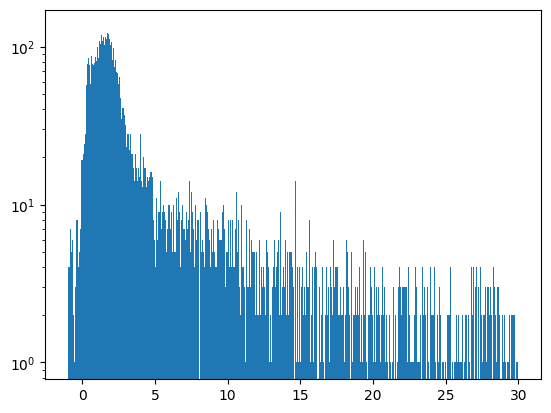

In [33]:

plt.hist(hitlets,range=(-1,30),bins=1000)
plt.yscale('log')
plt.show()